<a href="https://colab.research.google.com/github/demolakstate/anomaly_detection_sport_video/blob/main/Convolutional_autoencoder_on_random_frames_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Connect to google drive##

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
data_dir = '/content/gdrive/MyDrive/Anomaly_Video_classification/random-cropping-frames/input_images'

In [3]:
cd /content/gdrive/MyDrive/Anomaly_Video_classification/random-cropping-frames

/content/gdrive/MyDrive/Anomaly_Video_classification/random-cropping-frames


## Random crop of videos ##

In [ ]:
#from random import randint

In [ ]:
# num_of_crops = 100
# videos = list()

# for _ in range(num_of_crops):
#   x = randint(0, 3840)
#   y = randint(0, 2160)
#   #videos.append(f'crop_{x}_by_{y}.mkv')
#   !ffmpeg -i safe_video/522.mkv -filter:v "crop=w=500:h=500:x={x}:y={y}" cropped_video/crop_{x}_by_{y}.mkv

In [4]:
import os

In [ ]:
safe_videos = os.listdir('safe_video')

In [ ]:
for safe_video in safe_videos:
  !ffmpeg -i safe_video/{safe_video} -filter:v "crop=w=500:h=500" cropped_video/crop_{safe_video}.mkv

In [5]:

videos = os.listdir('cropped_video/')

## Extract frames ##

In [6]:
for video in videos:
  print(f'video: {video}')
  !ffmpeg -i cropped_video/{video} -qscale:v 2 -r 200.0 input_images/data/{video}-%4d.jpg

video: crop_004.mp4.mkv
ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --ena

##Import TensorFlow and other libraries##

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [8]:
import tensorflow_datasets as tfds

In [9]:
from tensorflow.keras.optimizers import Adam, SGD

In [10]:
#import PIL

In [11]:
#img = PIL.Image.open(data_dir + "/data/0014.jpg")

##Load the dataset##

In [12]:
#create dataset

batch_size = 1000000
img_height = img_width = 200


#data_dir = '/content/gdrive/MyDrive/anomaly_detection_task/'

In [13]:
x_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1552 files belonging to 1 classes.
Using 1242 files for training.


In [14]:
x_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1552 files belonging to 1 classes.
Using 310 files for validation.


##Visualize the data##

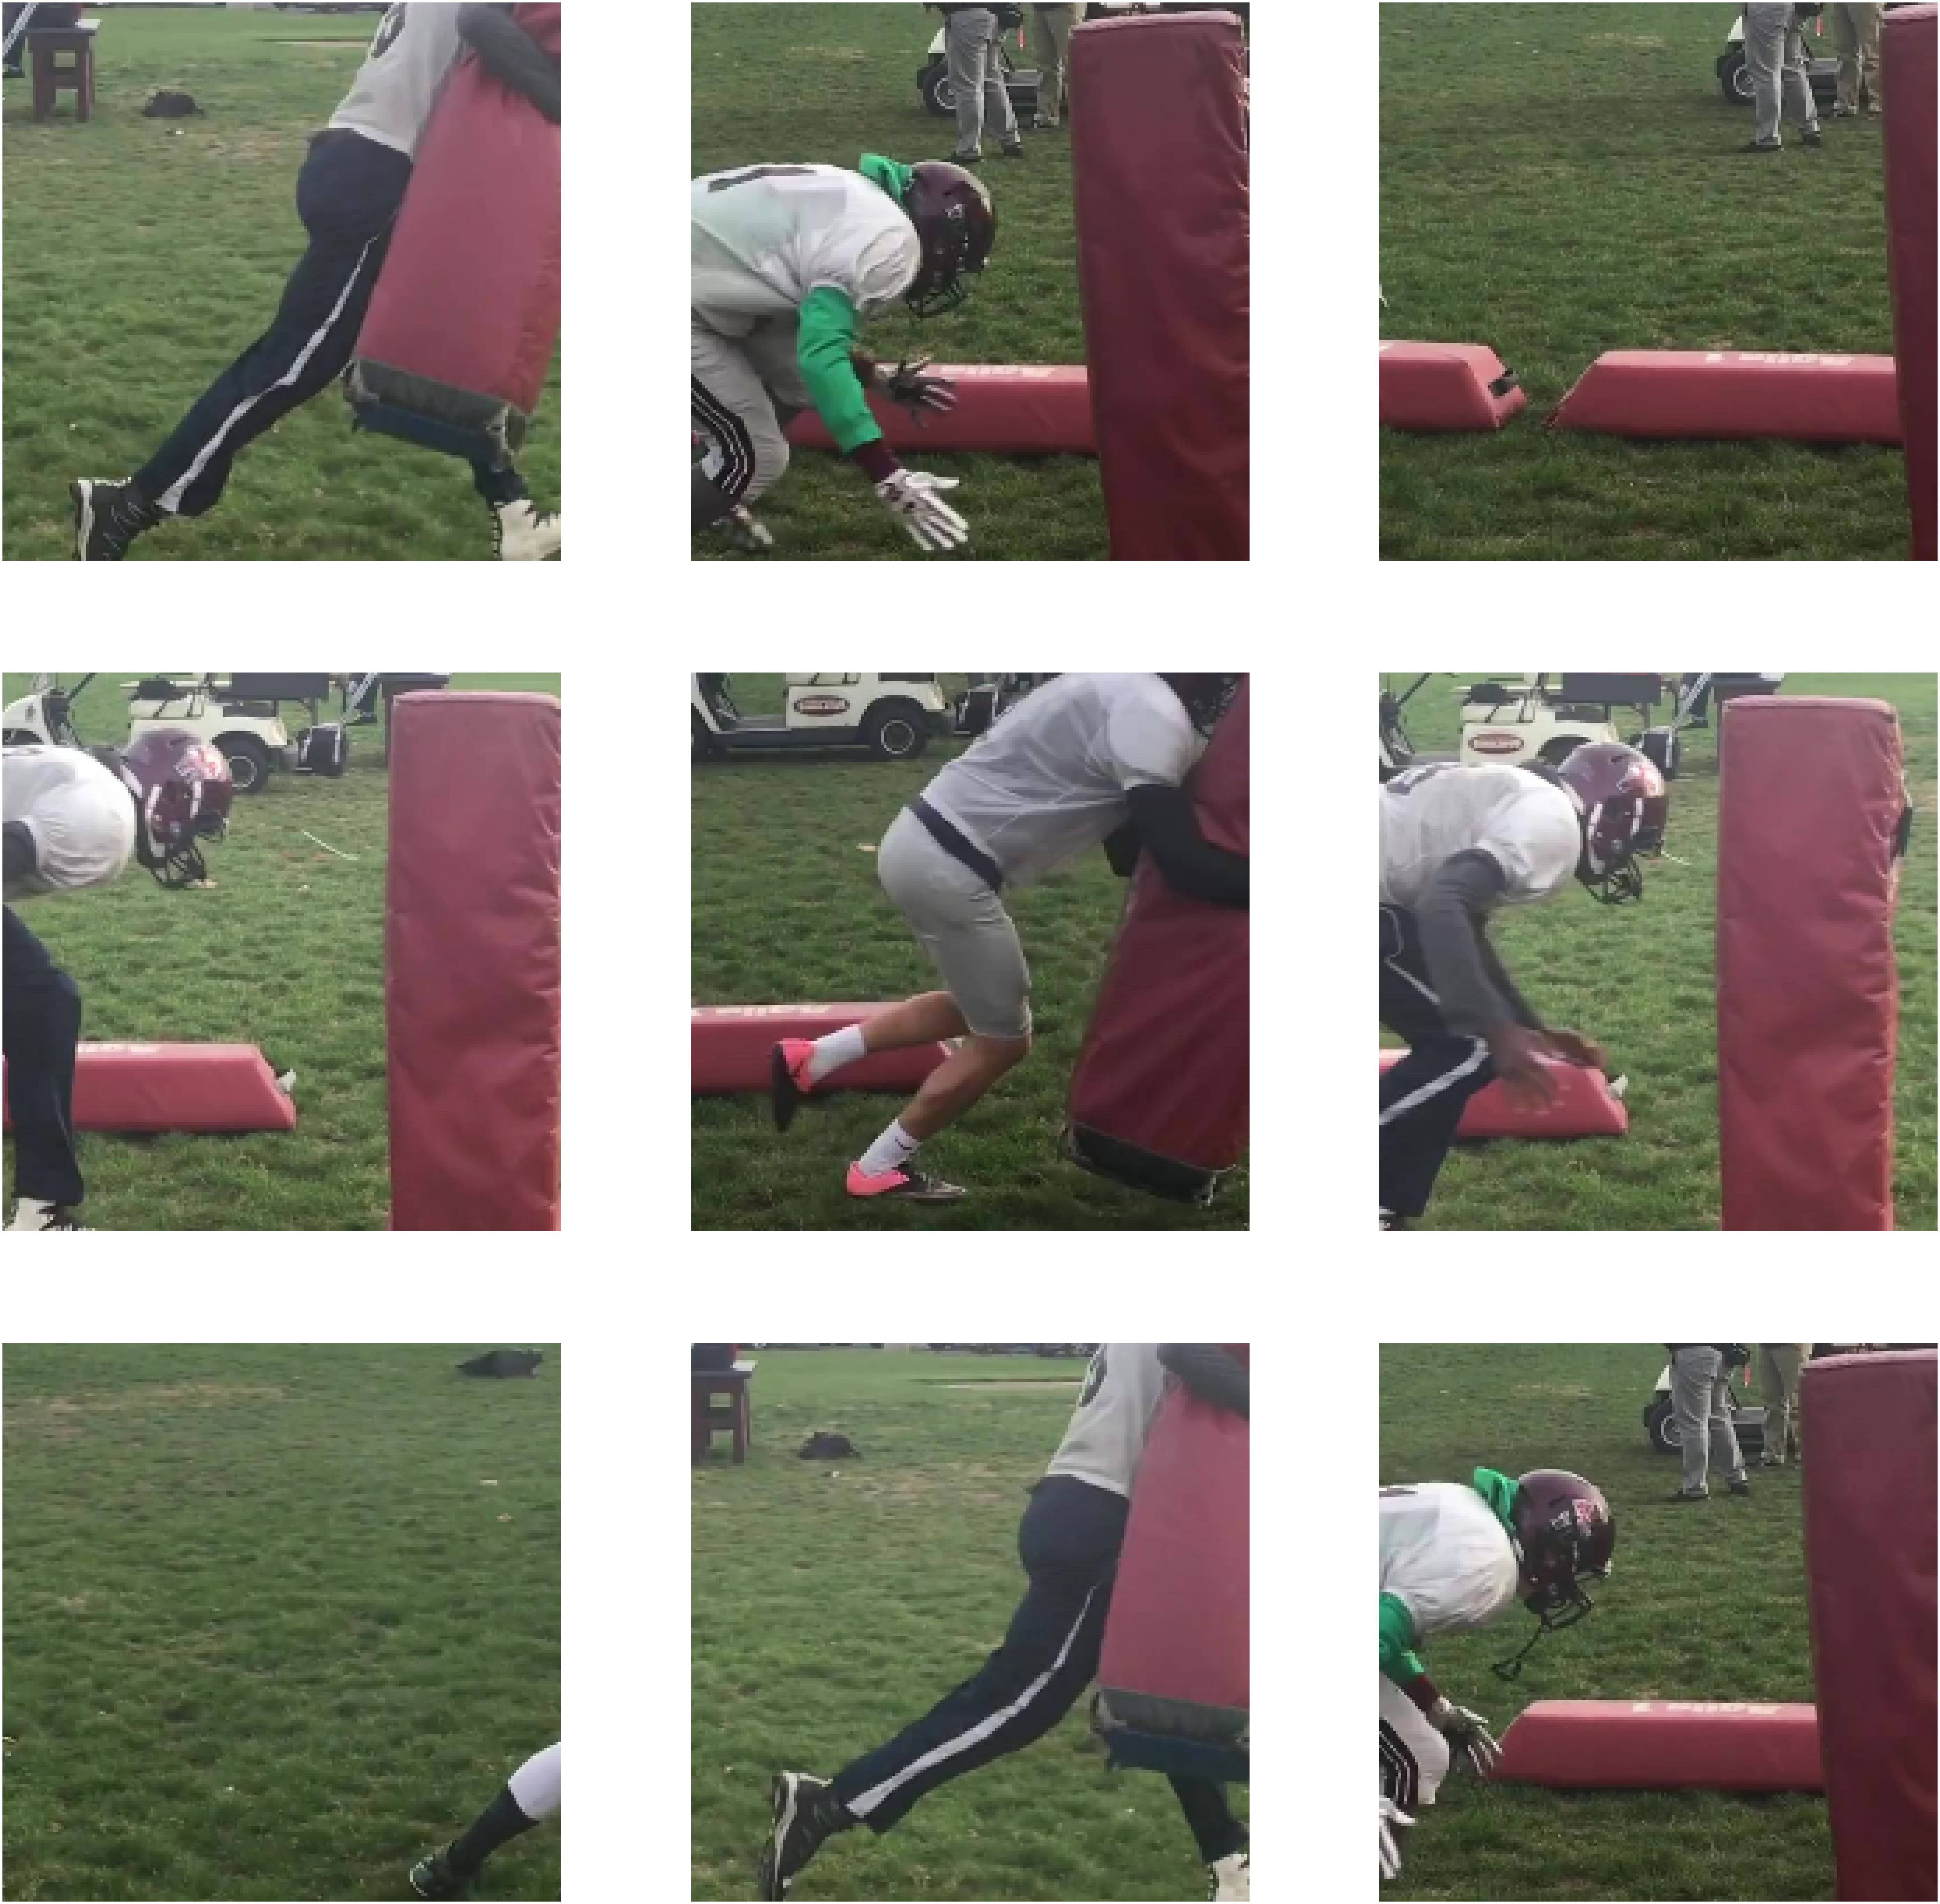

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(100, 100))
for images, labels in x_train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    #plt.title(class_names[labels[i]])
    plt.axis("off")

##Convert tf.data.Dataset to Numpy arrays##

In [16]:
import tensorflow_datasets as tfds

In [17]:
for image, label in tfds.as_numpy(x_train_ds):
  #print(type(image), type(label), label, len(label))
  x_train = image
  #print('------')

In [18]:
for image, label in tfds.as_numpy(x_test_ds):
  #print(type(image), type(label), label, len(label))
  x_test = image
  #print('------')

In [19]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

##Convolutional Autoencoder architecture##

In [20]:
## Hyperparameters
C = 3
## Latent space
latent_dim = 128

In [21]:
## Building the encoder
inputs = layers.Input(shape=(img_height, img_width, C), name="inputs")
x = inputs

x = layers.Conv2D(32, (3,3), padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.MaxPool2D((2,2))(x)

x = layers.Conv2D(32, (3,3), padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.MaxPool2D((2,2))(x)

print('shape after encoder: ', x.shape)

x = layers.Flatten()(x)
units = x.shape[1]
x = layers.Dense(latent_dim, name="latent")(x)


## Building the decoder
x = layers.Dense(units)(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Reshape((50, 50, 32))(x)

x = layers.Conv2DTranspose(64, (3, 3), strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha=0.2)(x)

x = layers.Conv2DTranspose(C, (3,3), strides=2, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("sigmoid", name="outputs")(x)

outputs = x

shape after encoder:  (None, 50, 50, 32)


In [22]:
print(x.shape)

(None, 200, 200, 3)


In [23]:
autoencoder = Model(inputs, outputs)
autoencoder.compile(optimizer=Adam(1e-3), loss='binary_crossentropy')
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 200, 200, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 200, 200, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 200, 200, 32)      128       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 200, 200, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 100, 100, 32)      128   

In [24]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)

In [25]:
history = autoencoder.fit(x_train, x_train,
                epochs=10000,
                batch_size=64,
                callbacks=[callback],
                shuffle=False,
                validation_data=(x_test, x_test),
                verbose=1)

Epoch 1/10000
20/20 [==============================] - 7s 140ms/step - loss: 0.7485 - val_loss: 1.0524
Epoch 2/10000
20/20 [==============================] - 2s 107ms/step - loss: 0.6970 - val_loss: 0.7419
Epoch 3/10000
20/20 [==============================] - 2s 109ms/step - loss: 0.6841 - val_loss: 0.6780
Epoch 4/10000
20/20 [==============================] - 2s 106ms/step - loss: 0.6741 - val_loss: 0.6677
Epoch 5/10000
20/20 [==============================] - 2s 109ms/step - loss: 0.6686 - val_loss: 0.6637
Epoch 6/10000
20/20 [==============================] - 2s 106ms/step - loss: 0.6623 - val_loss: 0.6661
Epoch 7/10000
20/20 [==============================] - 2s 107ms/step - loss: 0.6565 - val_loss: 0.6673
Epoch 8/10000
20/20 [==============================] - 2s 107ms/step - loss: 0.6515 - val_loss: 0.6642
Epoch 9/10000
20/20 [==============================] - 2s 106ms/step - loss: 0.6472 - val_loss: 0.6598
Epoch 10/10000
20/20 [==============================] - 2s 107ms/step - l

## Visualize the model loss ##

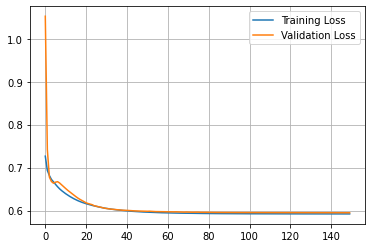

In [26]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
#plt.xkcd()
plt.grid()
plt.legend()

In [27]:
#dir(plt)

In [28]:
test_pred_y = autoencoder.predict(x_test)

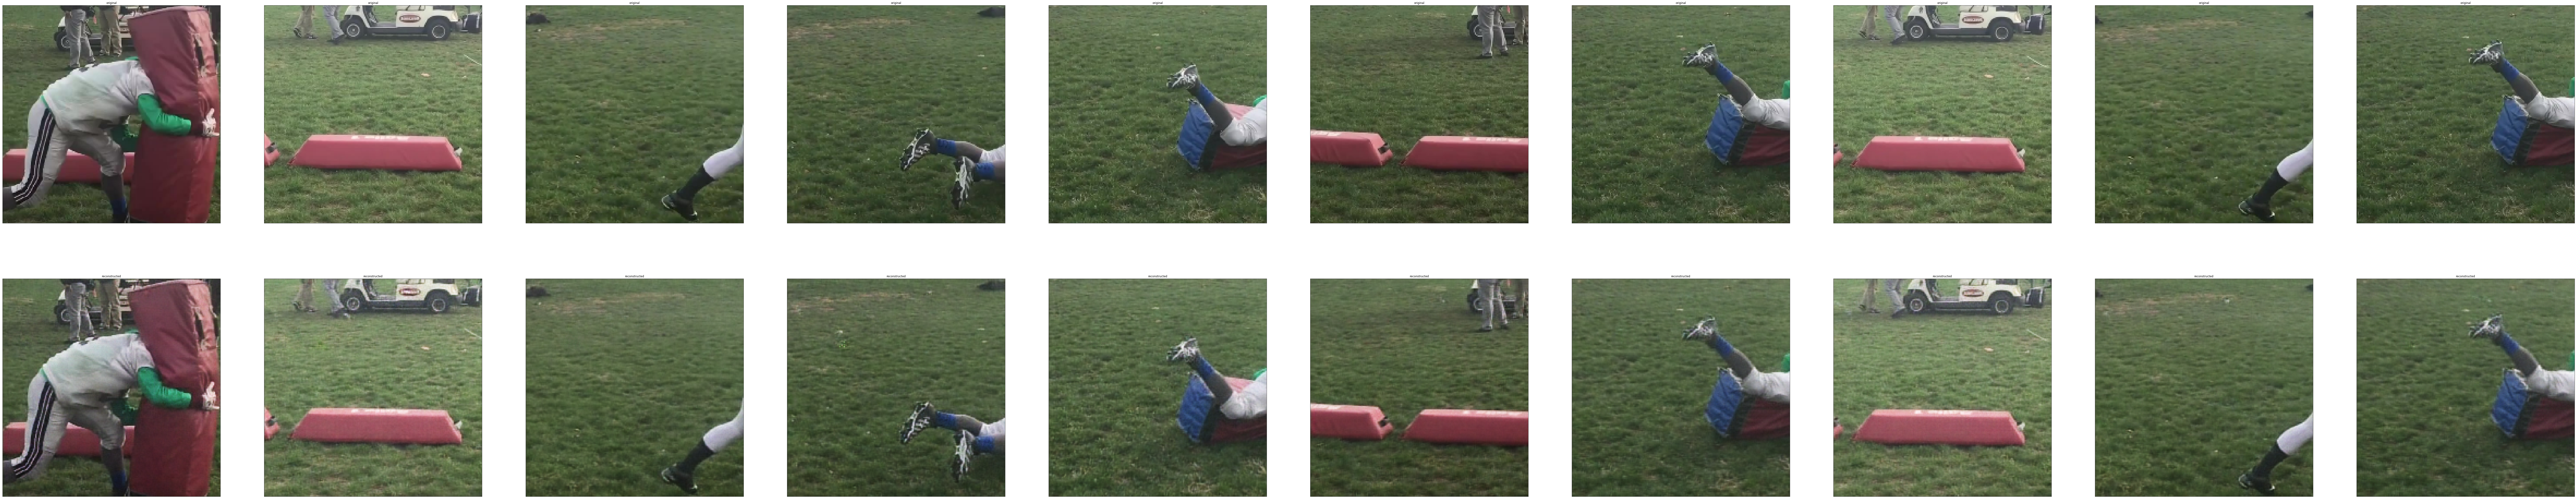

In [29]:
#n = len(x_test)
n = 10
plt.figure(figsize=(200, 40))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  #print(f'i: {i}')
  plt.imshow(x_test[-i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(test_pred_y[-i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()